In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time

import sys
sys.path.insert(0, '../')

In [2]:
from libra import trappist1, transit_model, trappist1_all_transits, ObservationArchive, trappist_out_of_transit

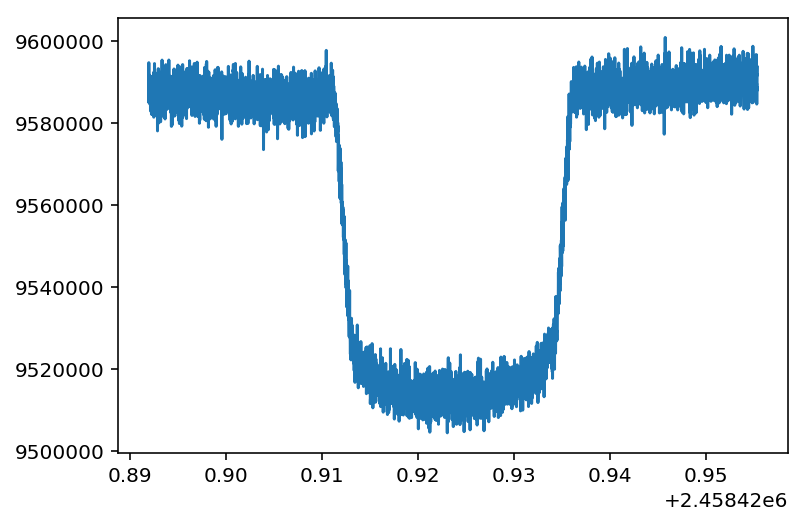

In [3]:
t0 = trappist1('b').t0
original_params = trappist1('b')
times = np.arange(t0-0.03, t0+0.03, 1/60/60/24)

from scipy.ndimage import gaussian_filter1d

with ObservationArchive('trappist1_bright2_b', 'r') as obs: 
    sim = obs.b[3]
    times = sim.times[:]
    spectra = sim.spectra[:]
    plt.plot(sim.times, np.sum(sim.spectra, axis=1))

Band integrated light curve: 

<Container object of 3 artists>

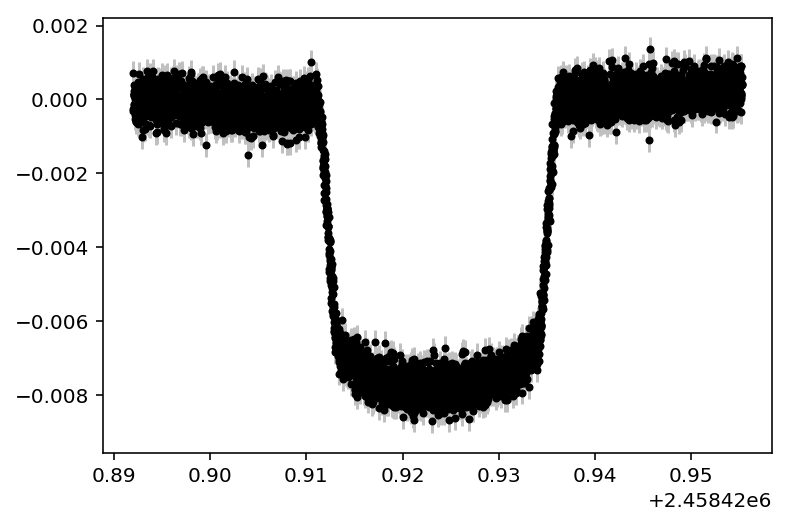

In [4]:
oot = trappist_out_of_transit(times)

fluxes = np.sum(spectra, axis=1)
oot_median = np.median(fluxes[oot])
errors = np.sqrt(fluxes) / oot_median
fluxes /= oot_median
fluxes -= 1

plt.errorbar(times, fluxes, errors, color='k', fmt='.', ecolor='silver')

Fit the band-integrated light curve with `celerite`

(0, 14)

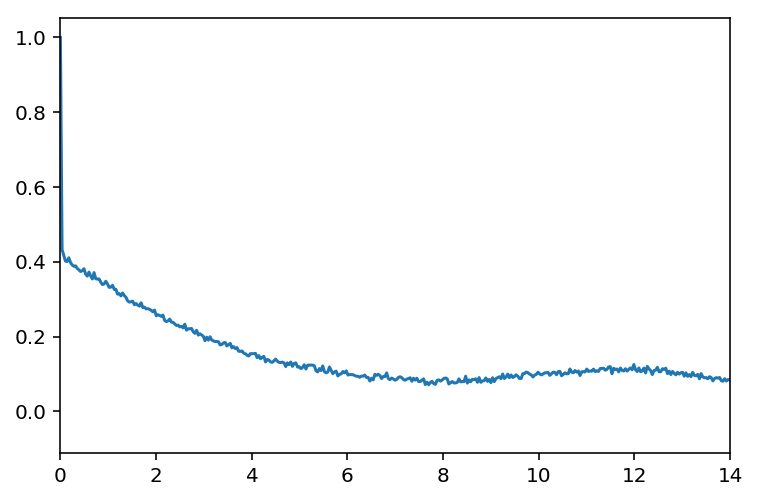

In [5]:
spitzer_time, spitzer_flux, spitzer_err, _ = np.loadtxt('../libra/data/T1_Spitzer.txt', 
                                              unpack=True, delimiter=',')

#plt.errorbar(spitzer_time, spitzer_flux, spitzer_err, fmt='.', alpha=0.3)

from interpacf import interpolated_acf

lag_spitzer, acf_spitzer = interpolated_acf(spitzer_time, spitzer_flux)

plt.plot(lag_spitzer*24, acf_spitzer/acf_spitzer.max())
plt.xlim([0, 14])

In [6]:
import celerite
from celerite import terms
from scipy.optimize import minimize
from celerite.modeling import Model
from copy import deepcopy

class MeanModel3Param(Model):
    parameter_names = ['amp', 'depth', 't0']

    def get_value(self, t):
        params = deepcopy(trappist1('b'))
        params.rp = self.depth**0.5
        params.t0 = self.t0 + original_params.t0
        return self.amp * transit_model(t, params)

initp_dict = dict(amp=np.median(fluxes), depth=original_params.rp**2,
                  t0=0)#t0=original_params.t0)

parameter_bounds = dict(amp=[0.9*np.min(fluxes), 1.3*np.max(fluxes)],
                        depth=[0.9 * original_params.rp**2,
                               1.1 * original_params.rp**2],
                        t0=[-0.05, 0.05])
    
mean_model = MeanModel3Param(bounds=parameter_bounds, **initp_dict)

Q = 1.0 / np.sqrt(2.0)
log_w0 = 4#3.0
log_S0 = 10

log_cadence_min = None # np.log(2*np.pi/(2./24))
log_cadence_max = np.log(2*np.pi/(0.25/24))

# bounds = dict(log_S0=(-15, 30), log_Q=(-15, 15),
#               log_omega0=(log_cadence_min, log_cadence_max))

# kernel = terms.SHOTerm(log_S0=log_S0, log_Q=np.log(Q),
#                        log_omega0=log_w0, bounds=bounds)

kernel = terms.RealTerm(log_a=0, log_c=np.log(6))

#kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
gp.compute(times - original_params.t0, errors)

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, #jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(fluxes, gp))
gp.set_parameter_vector(soln.x)

In [7]:
soln.x

array([ -1.17398594e+01,   2.59290227e+00,  -6.61543981e-04,
         7.07000000e-03,   0.00000000e+00])

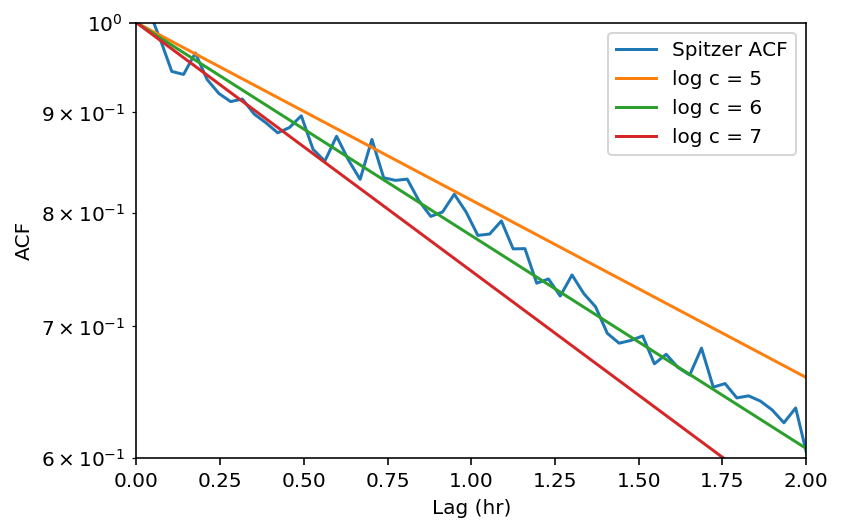

In [8]:
plt.plot(lag_spitzer*24, acf_spitzer/np.percentile(acf_spitzer, 99.99), label='Spitzer ACF')

for i in range(5, 8):
    kernel = terms.RealTerm(log_a=2, log_c=np.log(i))

    acf_kernel = kernel.get_value(lag_spitzer)
    plt.plot(lag_spitzer*24, acf_kernel/acf_kernel.max(), label='log c = {}'.format(i))

plt.yscale('log')
plt.legend()
plt.xlim([0, 2])
plt.ylim([6e-1, 1])
plt.xlabel('Lag (hr)')
plt.ylabel('ACF')
plt.savefig('acf_exp.png', dpi=250, bbox_inches='tight')

Plot the optimized GP over the band-integrated light curve

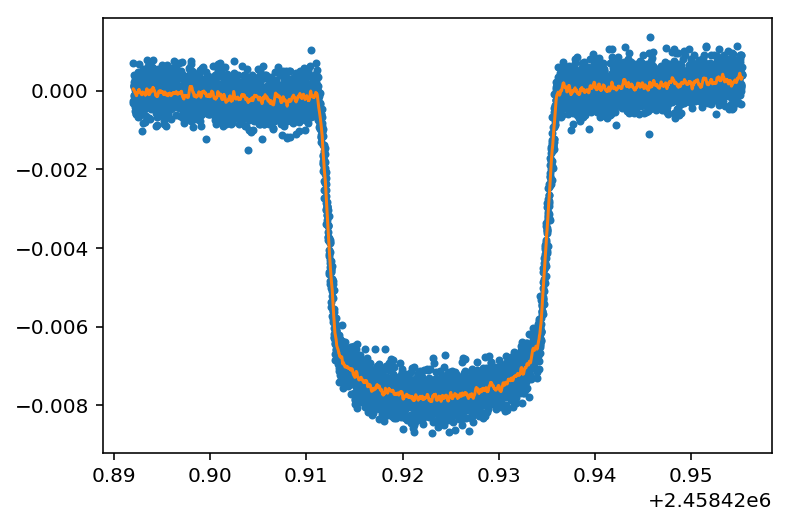

In [9]:
mu, var = gp.predict(fluxes, times - original_params.t0, return_var=True)
std = np.sqrt(var)

fixed_transit_model = mu.copy()

plt.plot(times, fluxes, '.')
plt.plot(times, mu)
#plt.fill_between(times, mu-std, mu+std, alpha=0.5, color='C1', zorder=10)

Plot the optimized light curve (without GP)

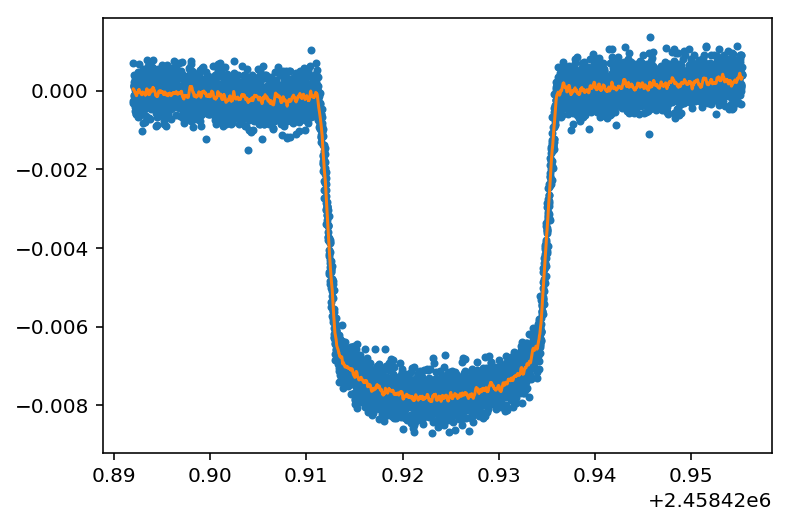

In [10]:
best_amp, best_depth, best_t0 = soln.x[2:]

params = deepcopy(original_params)
params.rp = best_depth**0.5
params.t0 = best_t0 + original_params.t0

# fixed_transit_model = transit_model(times, params)

plt.plot(times, fluxes, '.')
plt.plot(times, fixed_transit_model)# - 1)

Plot the normalized versions of the observations and model, for scaling with least squares:

In [428]:

# single_channel_flux = spectra[:, 100].copy()
# single_channel_error = np.sqrt(single_channel_flux)

# #single_channel_spectrum /= np.median(single_channel_spectrum[oot])
# #single_channel_spectrum -= 1 

# plt.errorbar(times, single_channel_spectrum, single_channel_error, fmt='.', color='k', ecolor='silver')

$${\displaystyle \mathbf {\hat {\beta }} =\left(\mathbf {X} ^{\mathtt {T}}\mathbf {\Omega } ^{-1}\mathbf {X} \right)^{-1}\mathbf {X} ^{\mathtt {T}}\mathbf {\Omega } ^{-1}\mathbf {y} .}$$
$$ V = \left(\mathbf {X} ^{\mathtt {T}}\mathbf {\Omega } ^{-1}\mathbf {X} \right)^{-1} $$

In [429]:
# # Following wikipedia notation
# X = np.vander(fixed_transit_model, 2)
# y = single_channel_flux
# err = single_channel_error

# omega = np.diag(err**2)
# omega_inv = np.linalg.inv(omega)

# V = np.linalg.inv(X.T @ omega_inv @ X)
# beta = V @ X.T @ omega_inv @ y

In [430]:
# print("beta =", beta)

# print("err:", np.sqrt(np.diag(V)))

In [431]:
# plt.errorbar(times, y, err, fmt='.', ms=1, ecolor='silver', color='k')

# plt.plot(times, X @ beta, color='r', zorder=10, lw=5)

***

In [437]:
cov = gp.get_matrix()

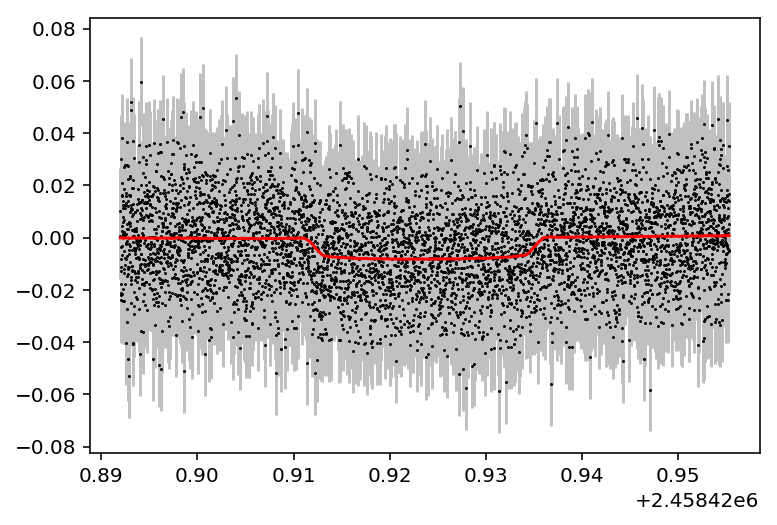

In [16]:
single_channel_flux = spectra[:, 390].copy()
single_channel_error = np.sqrt(single_channel_flux)

#X = fixed_transit_model[:, np.newaxis]# - 1
X = np.vstack([fixed_transit_model, (times - times.mean()), (times - times.mean())**2]).T# - 1
y = single_channel_flux / np.median(single_channel_flux[oot]) - 1
err = single_channel_error / np.median(single_channel_flux[oot])

omega = np.diag(err**2)# + cov
omega_inv = np.linalg.inv(omega)

V = np.linalg.inv(X.T @ omega_inv @ X)
beta = V @ X.T @ omega_inv @ y

plt.errorbar(times, y, err, fmt='.', color='k', ms=1, ecolor='silver')
plt.plot(times, X @ beta, 'r', zorder=10)

In [459]:
beta, np.sqrt(np.diag(V))

(array([ 0.97073498, -0.00311529,  0.1184523 ]),
 array([ 0.01550881,  0.00376233,  0.15353583]))

In [463]:
from numpy.linalg import LinAlgError 
from astropy.utils.console import ProgressBar

betas = np.zeros(spectra.shape[1])
betas_errs = np.zeros(spectra.shape[1])

with ProgressBar(len(betas), ipython_widget=True) as bar:
    for i in range(spectra.shape[1]):
        single_channel_flux = spectra[:, i].copy()
        single_channel_error = np.sqrt(single_channel_flux)

        #X = fixed_transit_model[:, np.newaxis]# - 1
        X = np.vstack([fixed_transit_model, (times - times.mean()), (times - times.mean())**2]).T
        y = single_channel_flux / np.median(single_channel_flux[oot]) - 1
        err = single_channel_error / np.median(single_channel_flux[oot])

        if not np.isnan(y).any():
            omega = np.diag(err**2) #+ cov
            omega_inv = np.linalg.inv(omega)

            V = np.linalg.inv(X.T @ omega_inv @ X)
            beta = V @ X.T @ omega_inv @ y
            betas[i] = beta[0]
            betas_errs[i] = np.sqrt(np.diag(V))[0]

        else:
            betas[i] = np.nan
            betas_errs[i] = np.nan
        bar.update()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


KeyboardInterrupt: 

(0.5, 5.5)

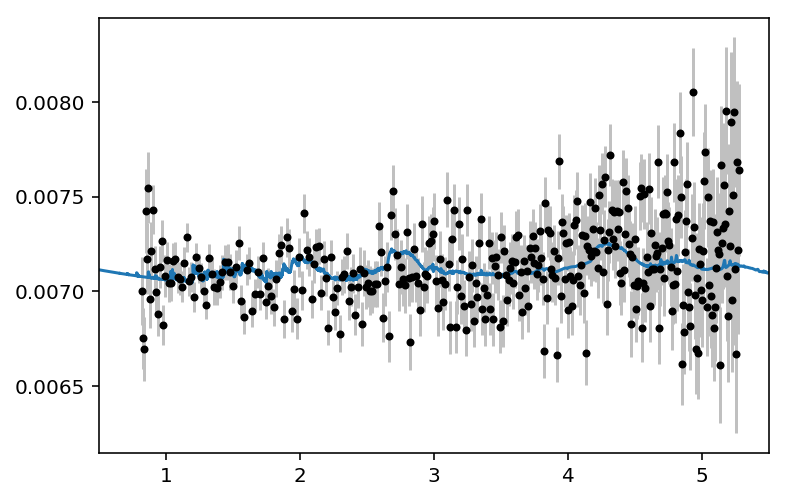

In [449]:
from libra import nirspec_pixel_wavelengths

wl = nirspec_pixel_wavelengths()

swl, sfl = np.loadtxt('../libra/data/transmission/t1b_10bar_venus_clear.txt', unpack=True)

rp = trappist1('b').rp
depth = rp**2
u = trappist1('b').u
ld_factor = 1 - u[0]/3 - u[1]/6

plt.errorbar(wl.value, betas * depth, betas_errs * depth, color='k', fmt='.', ecolor='silver')
plt.plot(swl, sfl * ld_factor)
plt.xlim([0.5, 5.5])

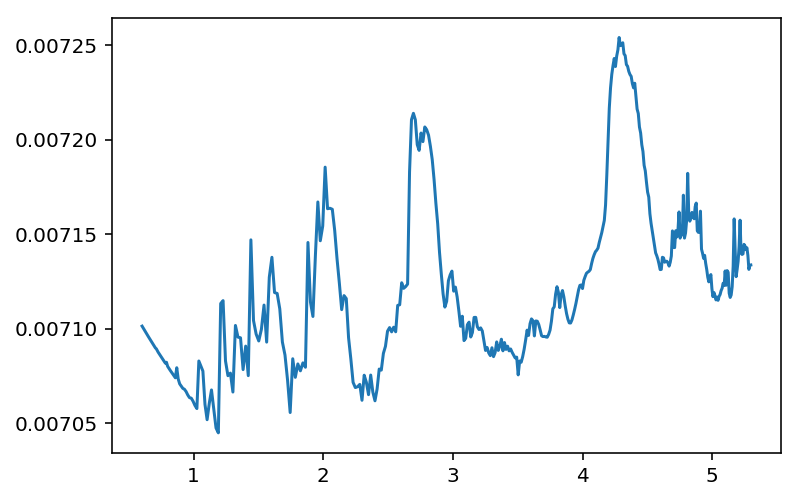

In [450]:
plt.plot(wl.value, np.interp(wl.value, swl, sfl * ld_factor))

In [451]:
red_chi2 = np.nansum((betas * depth - np.interp(wl.value, swl, sfl * ld_factor))**2 / 
                     (betas_errs * depth)**2) / len(betas)

red_chi2

1.5681112998485867